# Build Initial Single Factor GAM Model
## Setup Jupyter Notebook

In [0]:
!pip install pygam

### Import packages

In [0]:
# Import external packages
import pandas as pd
import os
import numpy as np
import random 
import pyarrow.parquet as pq
import sys
import shutil
import pickle
import warnings
from itertools import chain

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error

from pygam import GAM, s, te, f, l, utils

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import optuna
from optuna.visualization import matplotlib as optunampl

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 260)
warnings.filterwarnings("ignore")

In [0]:
# Import the internal package
package_loc = r""

# Add the package location to system paths
sys.path.append(package_loc)

from src import utility
from src.gam import training, explain

### Define Paths

In [0]:
###########################################################################
###########################################################################

product = "DB"
model_type = "GAM"
path = f"{product}"
model_version = "v3"

###########################################################################
###########################################################################

# Define the directories for input and output
dir_input = f"{path}/Input"
dir_data = f"{path}/{model_type}/Export"
dir_output = (
    f"{path}/{model_type}/Output"
    if model_version == ""
    else f"{path}/{model_type}/Output/{model_version}"
)

print(os.listdir(dir_input))
print(os.listdir(dir_data))
print(os.listdir(dir_output))

['CMI Numerical Bands.xlsx', 'CMI TA DB 2016 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2017 Datasheet v02 2024-06-17.xlsb', 'CMI TA DB 2018 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2019 Datasheet v01 2022-05-20.xlsb', 'CMI TA DB 2020 Datasheet v01 2022-05-20.xlsb']
['CMI DB Categorical Bands (with CalendarYear).xlsx', 'CMI DB Categorical Bands.xlsx', 'db_gam_modelling_data.parquet', 'db_gam_modelling_data_v2.parquet']
['02_model_note_db_gam_v3.xlsx', 'db_gam_initial_v3.pkl']


## Create Modelling Data

In [0]:
###########################################################################
###########################################################################

data_version = "v2"
model_data_file = f"db_gam_modelling_data_{data_version}.parquet"

###########################################################################
###########################################################################

model_data = pd.read_parquet(f"{dir_data}/{model_data_file}")
model_data

In [0]:
###########################################################################
###########################################################################

claim_count = "IncurredClaims"
claim_freq = "AnnualFreq"
weight = "LivesExposure"

# Define the list of numerical features
num_feat = [
    "CommencementYear_level",
    "SumAssuredBand_level",
    "Age_level",
    "Duration_level",
]

# Define the list of categorical features
cat_feat = [
    "ProductCategory_cat_level",
    "Gender_cat_level",
    "SmokerStatus_cat_level",
    "DistributionChannel_cat_level",
    "JointLifeStatus_cat_level",
    "CalendarYear_cat_level"
]

###########################################################################
###########################################################################

# Define the target for GAM
model_data[claim_freq] = model_data[claim_count] / model_data[weight]

# Define the full feature list
all_feat = num_feat + cat_feat
print(all_feat)

['CommencementYear_level', 'SumAssuredBand_level', 'Age_level', 'Duration_level', 'ProductCategory_cat_level', 'Gender_cat_level', 'SmokerStatus_cat_level', 'DistributionChannel_cat_level', 'JointLifeStatus_cat_level', 'CalendarYear_cat_level']


In [0]:
# Check the number of rows with null target
print(model_data[model_data[claim_freq].isnull()].shape[0])

1192


In [0]:
# Null values in the target are caused by zero exposure in the data
model_data[model_data[claim_freq].isnull()].head()

In [0]:
# Need to remove rows with 0 exposures
model_data = model_data[
    ~(
        (model_data[claim_freq].isnull())
        | (model_data[claim_freq] == np.inf)
    )
]
model_data

In [0]:
# Count null values for all columns
model_data.isnull().sum()

ProductCategory                  0
Gender                           0
SmokerStatus                     0
DistributionChannel              0
CommencementYear                 0
JointLifeStatus                  0
SumAssuredBand                   0
Age                              0
Duration                         0
LivesExposure                    0
AmountsExposure                  0
IncurredClaims                   0
AmountIncurred                   0
ExpectedClaims                   0
ExpectedAmountClaims             0
ComparatorTable                  0
CalendarYear                     0
holdout                          0
random_fold                      0
CommencementYear_level           0
SumAssuredBand_level             0
Age_level                        0
Duration_level                   0
ProductCategory_cat_level        0
Gender_cat_level                 0
SmokerStatus_cat_level           0
DistributionChannel_cat_level    0
JointLifeStatus_cat_level        0
CalendarYear_cat_lev

### Downsample of 0s in the training data

In [0]:
###########################################################################
###########################################################################

holdout = "holdout"

# Define the sample size of data with no claims 
sample_size = 1500000
random_seed = 653

###########################################################################
###########################################################################

train0 = model_data[(model_data[claim_freq] == 0) & (model_data[holdout] == 0)]
train1 = model_data[(model_data[claim_freq] > 0) & (model_data[holdout] == 0)]

# Generate a list of random numbers without replacement
random.seed(random_seed)
random_numbers = random.sample(
    list(range(len(train0))), len(train0)
)

# Define a random sample that consists of a down-sample of 0 and all the rows with claims
index0 = random_numbers[:sample_size]
train0_rs = train0.iloc[index0]
train_rs = pd.concat([train0_rs, train1], axis=0)
train_rs

In [0]:
# Calculate the actual frequency in the sample vs the one in the full training data
cf_rs = train_rs[claim_count].sum() / train_rs[weight].sum()

cf = (
    model_data[model_data[holdout] == 0][claim_count].sum()
    / model_data[model_data[holdout] == 0][weight].sum()
)

print(f"Actual Freq in the down-sample: {cf_rs:.4%}")
print(f"Actual Freq in the full training data: {cf:.4%}")

Actual Freq in the down-sample: 0.1696%
Actual Freq in the full training data: 0.1314%


In [0]:
# Calculate the base adjustment required to to applied to the model outputs
base_adj = cf / cf_rs
print(f"Base Adjustment: {base_adj:.4f}")

Base Adjustment: 0.7744


### Define required dataframes

In [0]:
###########################################################################
###########################################################################

holdout = "holdout"
random_fold = "random_fold"
num_fold = 5  # Number of folds in the training data

###########################################################################
###########################################################################

# Define the training and holdout dataframes
X_train_rs = train_rs[all_feat]
y_train_rs = train_rs[claim_freq]
w_train_rs = train_rs[weight]

X_test = model_data.loc[model_data[holdout] == 1, all_feat]
y_test = model_data.loc[model_data[holdout] == 1, claim_freq]
w_test = model_data.loc[model_data[holdout] == 1, weight]

# Define the cross-validation folds required for hyperparameter tuning
random_fold_values = train_rs[random_fold].values

# Define a list of tuples, each first element contains indices for the training fold and each  second element contains indices for the holdout
folds = []
df_ = pd.DataFrame(
    zip(range(len(random_fold_values)), random_fold_values),
    columns=["row_index", random_fold],
)

for i in range(num_fold):
    index_train = df_[df_[random_fold] != i + 1]["row_index"].to_list()
    index_valid = df_[df_[random_fold] == i + 1]["row_index"].to_list()
    folds.append((index_train, index_valid))

valid_folds = [k[1] for k in folds]
check = np.sort(np.array(list(chain(*valid_folds)))) == np.arange(len(X_train_rs))

assert check.sum() == len(
    X_train_rs
), "Not all the rows in the training data are included in the data folds."

In [0]:
# Create a term string for GAM training
term_string, num_feat_map, cat_feat_map, _ = training.create_term_structure(
    num_feat,
    cat_feat,
    X_train_rs,
)
print(term_string)

s(0, lam=lam_num, n_splines=n_splines)+ s(1, lam=lam_num, n_splines=n_splines)+ s(2, lam=lam_num, n_splines=n_splines)+ s(3, lam=lam_num, n_splines=n_splines) + f(4, lam=lam_cat) + f(5, lam=lam_cat) + f(6, lam=lam_cat) + f(7, lam=lam_cat) + f(8, lam=lam_cat) + f(9, lam=lam_cat)


In [0]:
# In any unseen data, any categorical level not in the training set will be mapped to the mode of the training set
for v in cat_feat:
    unique_level = X_train_rs[v].unique()
    condition = X_test[v].isin(unique_level)
    X_test[v] = np.where(condition, X_test[v], X_train_rs[v].mode().iloc[0])
X_test

In [0]:
# Create training and validation sets for each permutation of the random folds
X_train_cv = {}
X_valid_cv = {}
w_train_cv = {}
w_valid_cv = {}
y_train_cv = {}
y_valid_cv = {}

for i, (train_index, valid_index) in enumerate(folds):
    X_train_cv[i] = X_train_rs.iloc[train_index]
    X_valid_cv[i] = X_train_rs.iloc[valid_index]

    # Any unseen level in the validation fold needs to be replaced by the mode in the training folds
    for v in cat_feat_map.values():
        unique_level = X_train_cv[i][v].unique()
        condition = X_valid_cv[i][v].isin(unique_level)
        X_valid_cv[i][v] = np.where(
            condition, X_valid_cv[i][v], X_train_cv[i][v].mode().iloc[0]
        )

    w_train_cv[i] = w_train_rs.iloc[train_index]
    w_valid_cv[i] = w_train_rs.iloc[valid_index]
    y_train_cv[i] = y_train_rs.iloc[train_index]
    y_valid_cv[i] = y_train_rs.iloc[valid_index]

## Hyperparameter Tuning

In [0]:
# create study
study = optuna.create_study(direction="minimize")

# define objective
objective = training.OptunaGamObjectiveCV(
    term_string,
    5,
    (6, 10), # Need to experiment with the range 
    (1, 1e3, True), 
    (1, 1e3, True),
    X_train_cv, 
    X_valid_cv, 
    y_train_cv, 
    y_valid_cv,
    w_train_cv, 
    w_valid_cv, 
)

[I 2024-10-06 06:26:07,269] A new study created in memory with name: no-name-d0af0d69-7e50-4773-88a8-b3cdb8026142


In [0]:
###########################################################################
###########################################################################

n_trials = 30

###########################################################################
###########################################################################

# do study
study.optimize(objective, n_trials=n_trials)

[I 2024-10-06 06:33:58,557] Trial 0 finished with value: 193724.39756458864 and parameters: {'n_splines': 8, 'lam_num': 629.3594881138165, 'lam_cat': 384.3549776743266, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 0 with value: 193724.39756458864.
[I 2024-10-06 06:41:38,747] Trial 1 finished with value: 193676.11475956076 and parameters: {'n_splines': 6, 'lam_num': 16.82896652658325, 'lam_cat': 629.8500174683633, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 1 with value: 193676.11475956076.
[I 2024-10-06 06:51:32,424] Trial 2 finished with value: 193640.22501945726 and parameters: {'n_splines': 10, 'lam_num': 27.42427746129266, 'lam_cat': 40.92292024908026, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}. Best is trial 2 with value: 193640.22501945726.
[I 2024-10-06 06:59:03,415] Trial 3 finished with value: 193799.6482171646 and parameters: {'n_splines': 7, 'lam_num': 740.0732309112518, 'lam_cat'

In [0]:
# Print best trial
best_trial_number = study.best_trial.number
best_trial_value = study.best_trial.value
print(f"Best trial: {best_trial_number} with value {best_trial_value}\n{'*'*80}")

# Print out the best parameters
best_hyperparams = study.best_params
print(best_hyperparams)

Best trial: 27 with value 193631.96527107674
********************************************************************************
{'n_splines': 8, 'lam_num': 1.7250524044511732, 'lam_cat': 172.33559979301845, 'n_splines_inter': 4, 'lam_num_inter': 1.0, 'lam_cat_inter': 1.0}


In [0]:
###########################################################################
###########################################################################

modelling_log = f"02_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"

###########################################################################
###########################################################################

with pd.ExcelWriter(
    f"/tmp/{modelling_log}", engine="openpyxl", mode="w"
) as writer:
    study.trials_dataframe().sort_values("value").to_excel(
        writer, sheet_name="Initial_Tune", index=False
    )

shutil.copyfile(
    f"/tmp/{modelling_log}",
    f"{dir_output}/{modelling_log}",
)

<Axes: title={'center': 'Empirical Distribution Function Plot'}, xlabel='Objective Value', ylabel='Cumulative Probability'>

<Figure size 640x480 with 0 Axes>

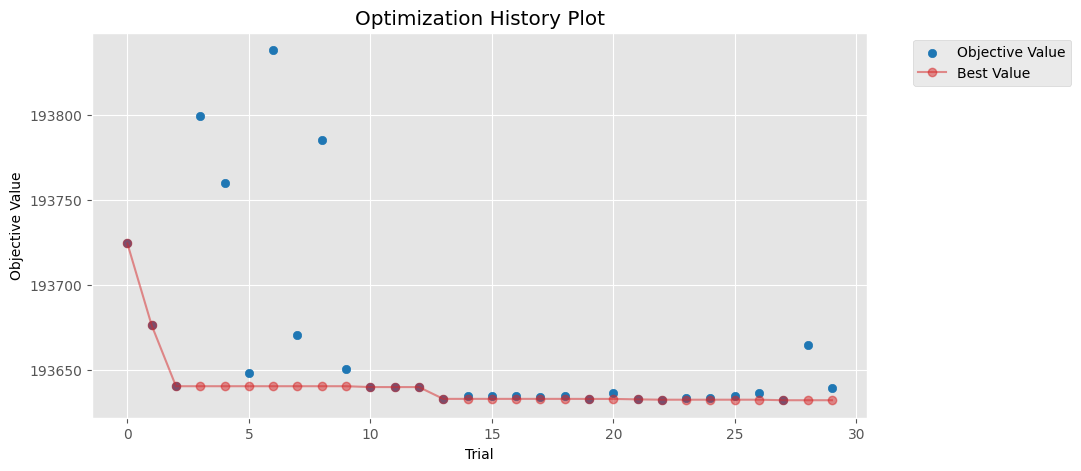

<Figure size 1000x500 with 0 Axes>

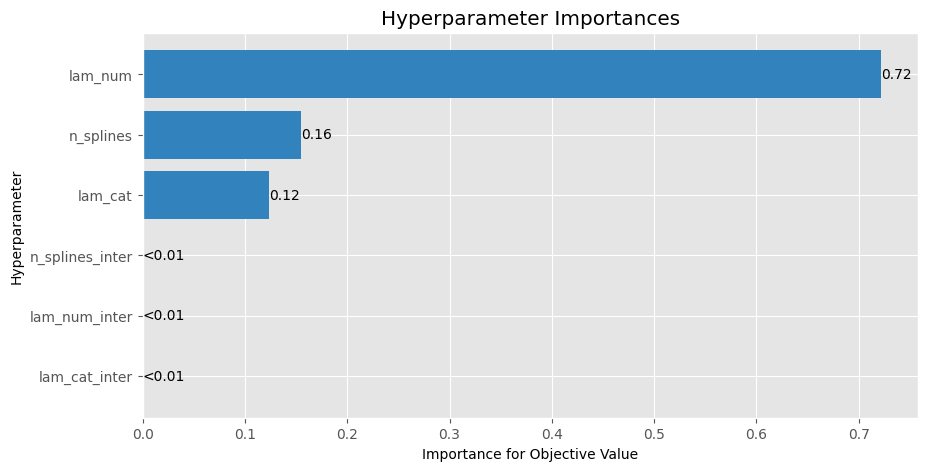

<Figure size 1000x500 with 0 Axes>

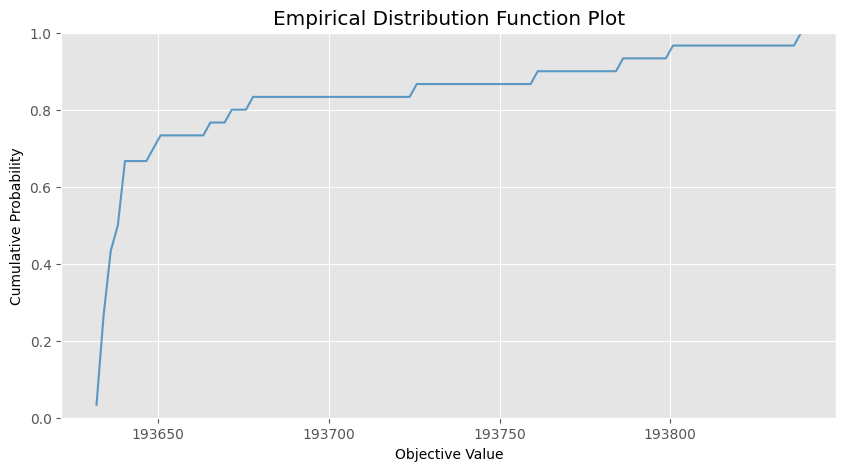

In [0]:
plt.figure()
plt.rcParams["figure.figsize"] = [10, 5]
optunampl.plot_optimization_history(study)

plt.figure()
plt.rcParams["figure.figsize"] = [10, 5]
optunampl.plot_param_importances(study) # Plot parameter importance

plt.figure()
plt.rcParams["figure.figsize"] = [10, 5]
optunampl.plot_edf(study) # Plot the empirical cumulative distribution plot

[W 2024-10-06 10:47:06,802] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([<Axes: xlabel='lam_cat', ylabel='Objective Value'>,
       <Axes: xlabel='lam_num'>, <Axes: xlabel='n_splines'>], dtype=object)

<Figure size 1000x500 with 0 Axes>

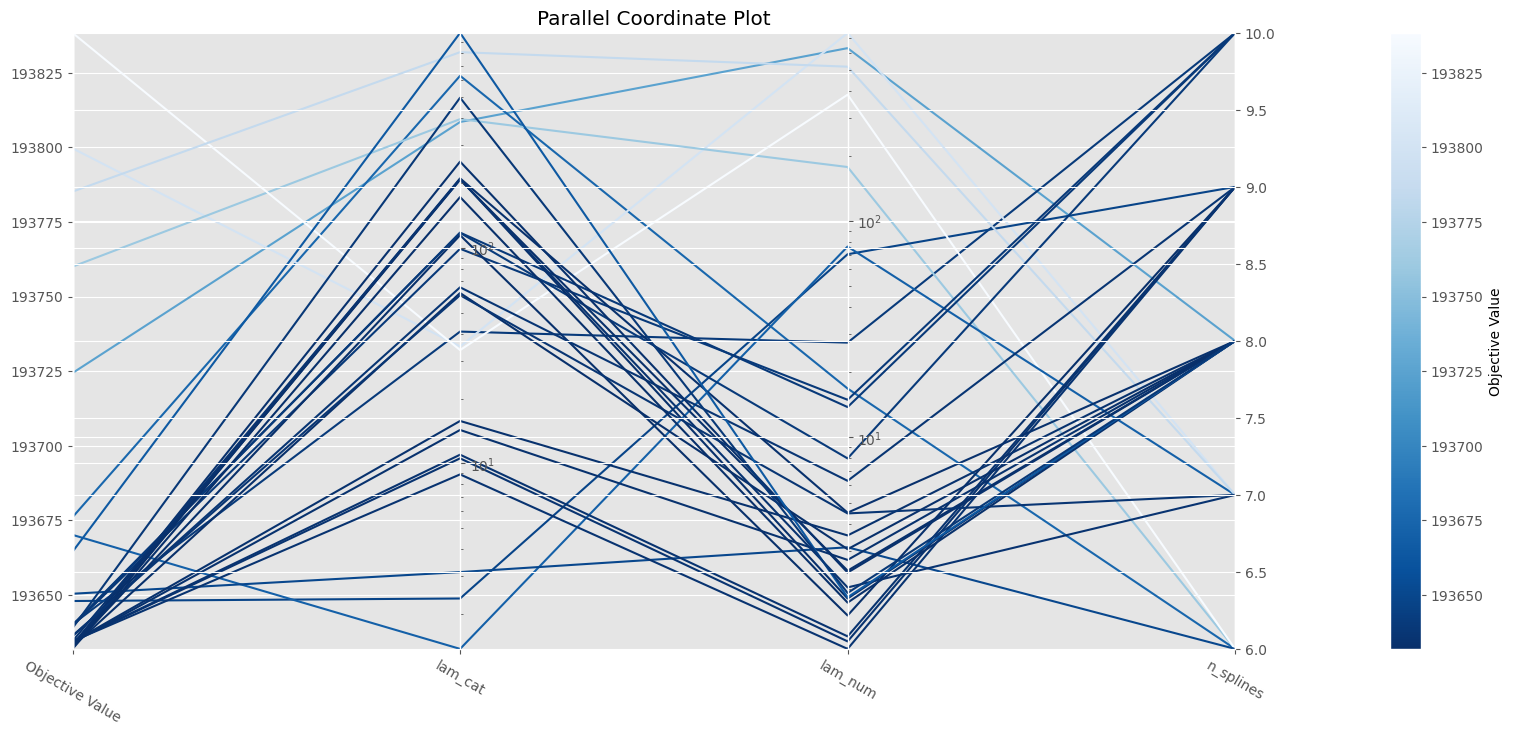

<Figure size 2000x800 with 0 Axes>

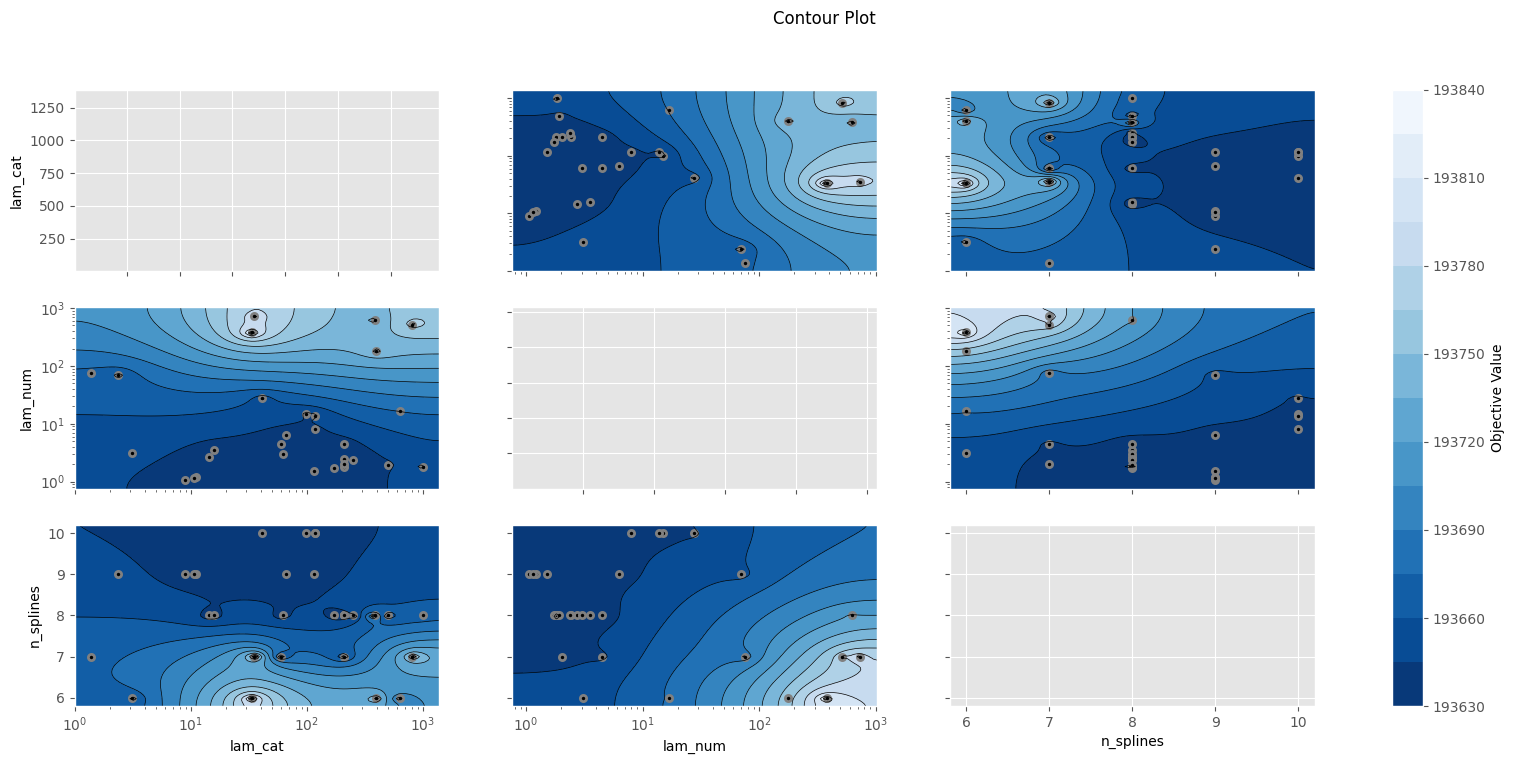

<Figure size 2000x800 with 0 Axes>

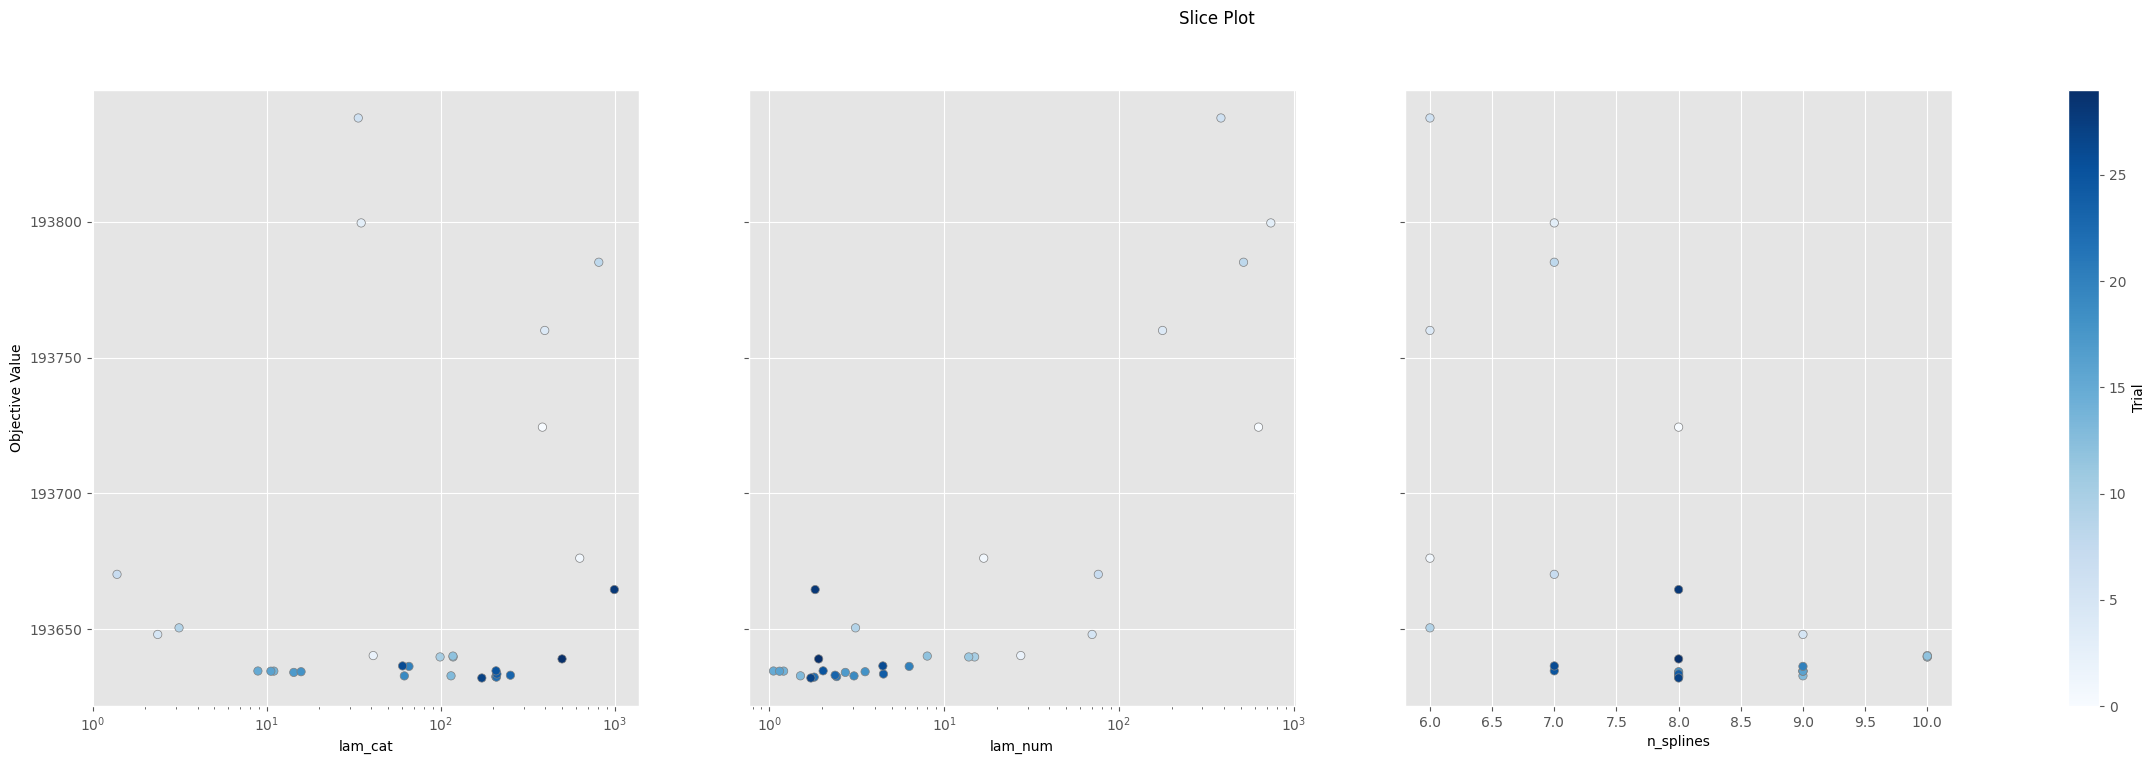

In [0]:
param_importance = optuna.importance.get_param_importances(study)

plt.figure()
plt.rcParams["figure.figsize"] = [20, 8]
optunampl.plot_parallel_coordinate(study, params=list(param_importance)[:3])

plt.figure()
plt.rcParams["figure.figsize"] = [20, 8]
optunampl.plot_contour(study, params=list(param_importance)[:3])

plt.figure()
plt.rcParams["figure.figsize"] = [20, 8]
optunampl.plot_slice(study, params=list(param_importance)[:3])

## Train Single Factor GAM Model

In [0]:
###########################################################################
###########################################################################

modelling_log = f"02_model_note_{product.lower()}_{model_type.lower()}_{model_version}.xlsx"

###########################################################################
###########################################################################

study_df = pd.read_excel(f"{dir_output}/{modelling_log}", "Initial_Tune")
best_params = study_df.sort_values("value").filter(regex="params_").iloc[0].to_dict()
best_params = {k.replace("params_", ""): v for k, v in best_params.items()}

n_splines = int(best_params["n_splines"])
lam_num = best_params["lam_num"]
lam_cat = best_params["lam_cat"]

print(f"n_splines: {n_splines}")
print(f"lam_num: {lam_num}")
print(f"lam_cat: {lam_cat}")

n_splines: 8
lam_num: 1.725052404451173
lam_cat: 172.3355997930184


In [0]:
# Fit the GAM model
gam_model = GAM(
    eval(term_string),
    distribution="poisson",
    link="log",
).fit(X_train_rs, y_train_rs, weights=w_train_rs)

gam_model.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     35.5415
Link Function:                          LogLink Log Likelihood:                                       -inf
Number of Samples:                      1535099 AIC:                                                   inf
                                                AICc:                                                  inf
                                                UBRE:                                               2.1262
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6415
Feature Function                  Lam

In [0]:
###########################################################################
###########################################################################

filename = f"{dir_output}/{product.lower()}_{model_type.lower()}_initial_{model_version}.pkl"

###########################################################################
###########################################################################

# Save the GAM model as a pickle file 
with open(filename, 'wb') as file:
    pickle.dump(gam_model, file)

### Derive associated relativities

In [0]:
# Extracting relativities by rating factors is necessary to implement the model in a rating-table strucutre
intercept, num_rel_dict, cat_rel_dict , _ = training.extract_relativity(
    num_feat_map,
    cat_feat_map,
    X_train_rs.join(w_train_rs), 
    gam_model,
    f"{dir_input}/CMI Numerical Bands.xlsx",
    f"{dir_data}/CMI DB Categorical Bands (with CalendarYear).xlsx",
    weight="LivesExposure",
    base_adj=base_adj,
)
print(intercept)

0.0011825568373772552


In [0]:
# Check one set of relativities for a rating factor
num_rel_dict["CommencementYear_level"]

,CommencementYear_level,pred,relativity,LivesExposure,rel_weight
0,1,0.715351,1.113349,4.186203e+05,2.994603e+05
1,2,0.730547,1.137000,2.065726e+05,1.509111e+05
2,3,0.738315,1.149090,4.513928e+05,3.332700e+05
3,4,0.741037,1.153326,6.138120e+05,4.548574e+05
4,5,0.741283,1.153708,8.079740e+05,5.989371e+05
5,6,0.741312,1.153755,8.710915e+05,6.457509e+05
6,7,0.740708,1.152814,7.658529e+05,5.672733e+05
7,8,0.737854,1.148373,7.992881e+05,5.897581e+05
8,9,0.731170,1.137969,9.061170e+05,6.625255e+05
9,10,0.719290,1.119480,8.872957e+05,6.382231e+05


## Model Explanation 
### Factor Strength

In [0]:
single_fact_df, _ = explain.factor_strength(num_rel_dict, cat_rel_dict, weight="LivesExposure")
single_fact_df

,feature,feature_type,factor_strength
0,Age,numerical,1.398524
1,SmokerStatus,categorical,0.392754
2,Duration,numerical,0.165768
3,Gender,categorical,0.134222
4,CommencementYear,numerical,0.117284
5,SumAssuredBand,numerical,0.098198
6,CalendarYear,categorical,0.036021
7,JointLifeStatus,categorical,0.027374
8,DistributionChannel,categorical,0.026674
9,ProductCategory,categorical,0.014804


In [0]:
# Append the factor strength table to the modelling log
with pd.ExcelWriter(
    f"/tmp/{modelling_log}", engine="openpyxl", mode="a", if_sheet_exists="replace"
) as writer:
    single_fact_df.to_excel(writer, sheet_name="Sing_Fac_Imp", index=False)

shutil.copyfile(
    f"/tmp/{modelling_log}",
    f"{dir_output}/{modelling_log}",
)

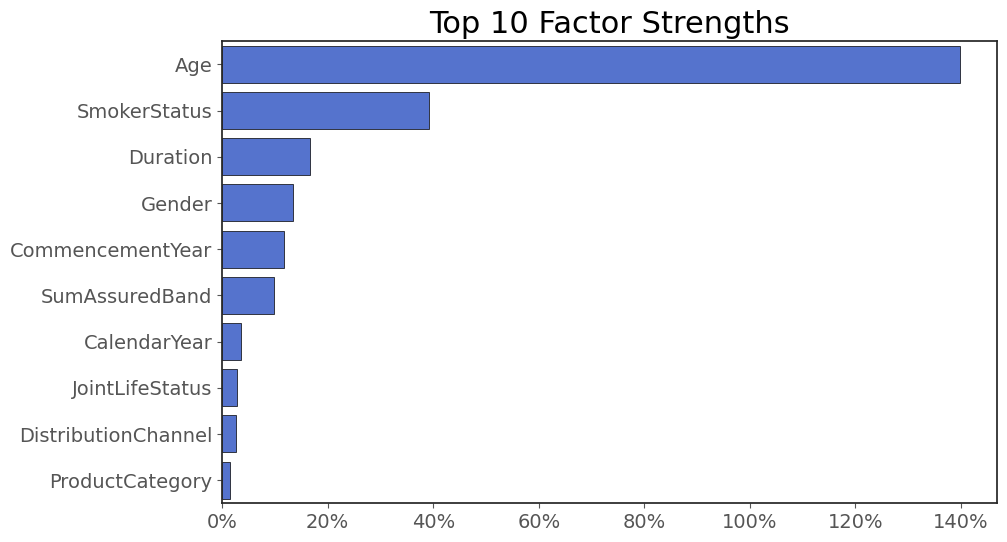

In [0]:
###########################################################################
###########################################################################

tick_fontsize = 14
label_fontsize = 18
title_fontsize = 22
n = 20

###########################################################################
###########################################################################

plt.rcParams["figure.figsize"] = [10, 6]
fig, ax = plt.subplots(1)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25

# Plot data
sns.barplot(
    x="factor_strength",
    y="feature",
    data=single_fact_df.head(n),
    ax=ax,
    color="royalblue",
    edgecolor="black",
)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))
ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
ax.set_title(
    f"Top {min(n, single_fact_df.shape[0])} Factor Strengths", fontsize=title_fontsize
)
ax.set_xlabel("")
ax.set_ylabel("")
ax.grid(False)
ax.set_facecolor("white")

### Rating Factor Trend Assessment

In [0]:
plot_object = explain.RatingFactorTrend(
    num_rel_dict,
    cat_rel_dict,
    f"{dir_input}/CMI Numerical Bands.xlsx",
    f"{dir_data}/CMI DB Categorical Bands (with CalendarYear).xlsx",
    weight="LivesExposure",
)

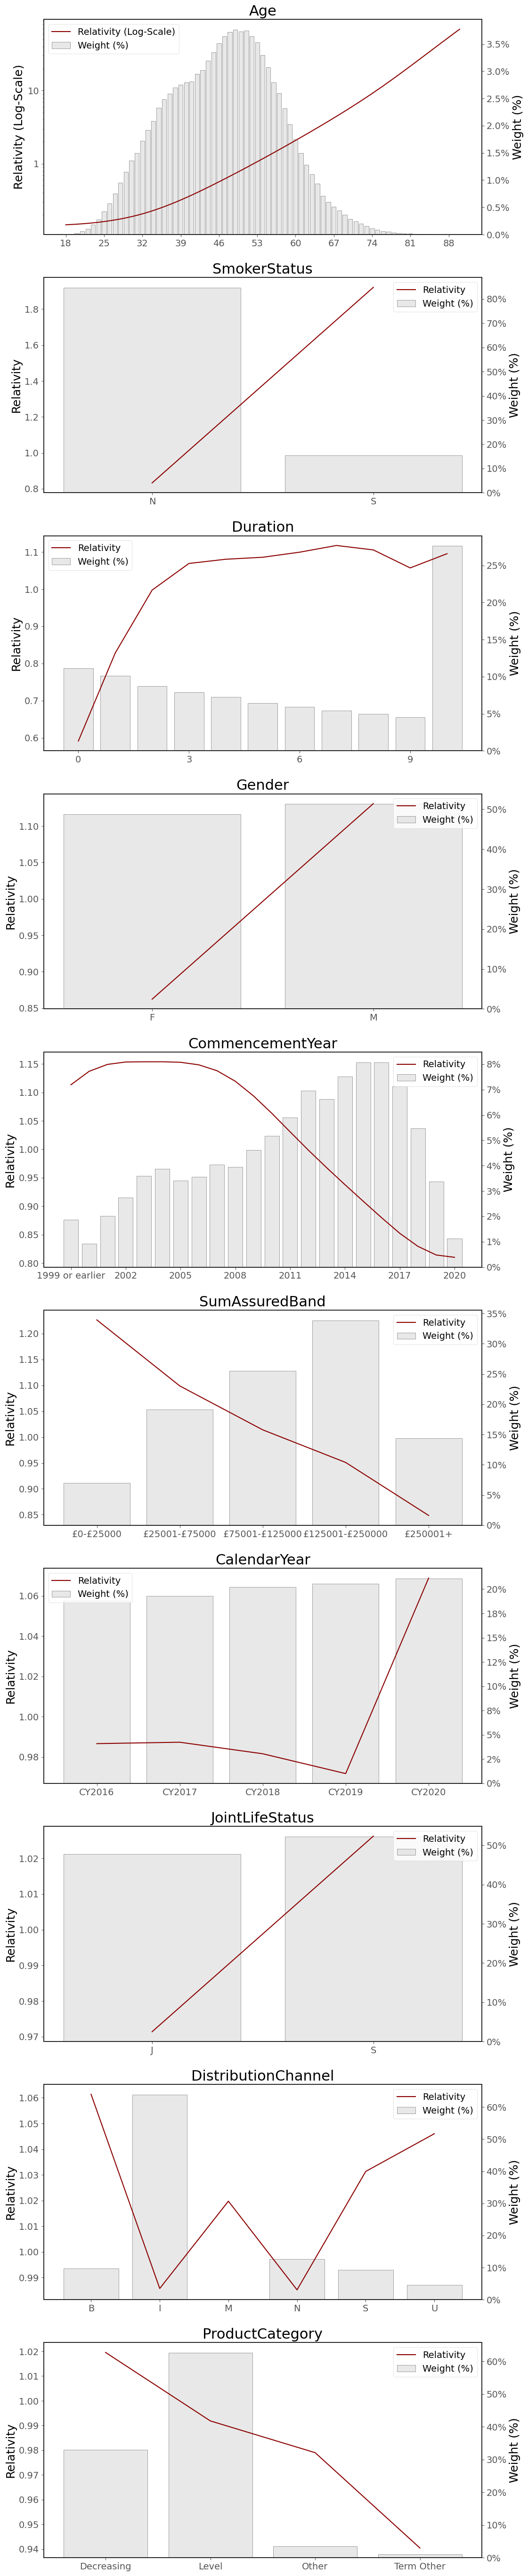

In [0]:
###########################################################################
###########################################################################

# Set the number of numerical variables to plot 
n = 20
num_plot = min(n, len(single_fact_df))

###########################################################################
###########################################################################

# plotting
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.25
plt.rcParams["figure.figsize"] = [12, 7 * num_plot]

fig, axs = plt.subplots(num_plot, 1)
plt.subplots_adjust(hspace=0.2)

for i, ax in enumerate(axs): 
    feature_type = single_fact_df.feature_type.iloc[i] 
    var = single_fact_df.feature.iloc[i]
    var += "_level" if feature_type == "numerical" else "_cat_level"
    log_scale = True if var == "Age_level" else False
    plot_object.plot_trend(var, ax, log_scale=log_scale)

## Holdout Assessment
### Holdout Scoring

In [0]:
# Define a procedure to score a dataset using the relativities extracted
X_test_rel = X_test.copy()
rel_list = []

for v, r in num_rel_dict.items():
    X_test_rel[v.replace("_level", "") + "_rel"] = X_test_rel[v].map(
        r.set_index(v)["relativity"].to_dict()
    )
    rel_list.append(v.replace("_level", "") + "_rel")

for v, r in cat_rel_dict.items(): 
    X_test_rel[v.replace("_cat_level", "") + "_rel"] = X_test_rel[v].map(
        r.set_index(v)["relativity"].to_dict()
    )
    rel_list.append(v.replace("_cat_level", "") + "_rel")

In [0]:
###########################################################################
###########################################################################

new_model_freq = "gam_freq"

###########################################################################
###########################################################################

ypred_test = gam_model.predict(X_test) * base_adj

ypred_test_df = pd.DataFrame(
    ypred_test, columns=[new_model_freq], index=X_test.index
)

# Check that there is no discrepancy between the GAM model predictions and the ones calculated using the relativities
ypred_test_df["gam_rel_freq"] = X_test_rel[rel_list].prod(axis=1) * intercept
ypred_test_df["check_diff"] = (ypred_test_df[new_model_freq] - ypred_test_df["gam_rel_freq"]).round(2)
print(ypred_test_df["check_diff"].sum())
ypred_test_df[ypred_test_df["check_diff"] != 0]

0.0


,gam_freq,gam_rel_freq,check_diff
unique_id,,,


In [0]:
###########################################################################
###########################################################################

cmi_base = "ExpectedClaims"
cmi_freq = "cmi_freq"
new_model_count = "gam_claim_count"

###########################################################################
###########################################################################

ypred_test_df = ypred_test_df.join(model_data[[weight, cmi_base, claim_count]])
ypred_test_df[new_model_count] = ypred_test_df[new_model_freq] * ypred_test_df[weight]

ypred_test_df[cmi_freq] = (
    ypred_test_df[cmi_base] / ypred_test_df[weight]
)

print(ypred_test_df.shape)
ypred_test_df.head()

(506840, 8)


,gam_freq,gam_rel_freq,check_diff,LivesExposure,ExpectedClaims,IncurredClaims,gam_claim_count,cmi_freq
unique_id,,,,,,,,
5,0.000305,0.000305,0.0,0.538251,0.000187,0.0,0.000164,0.000347
6,0.000455,0.000455,-0.0,0.426230,0.000231,0.0,0.000194,0.000542
16,0.000899,0.000899,-0.0,0.002732,0.000003,0.0,0.000002,0.001012
26,0.000965,0.000965,-0.0,0.248634,0.000299,0.0,0.000240,0.001201
38,0.000418,0.000418,0.0,0.658470,0.000326,0.0,0.000275,0.000495


### Distribution Comparison

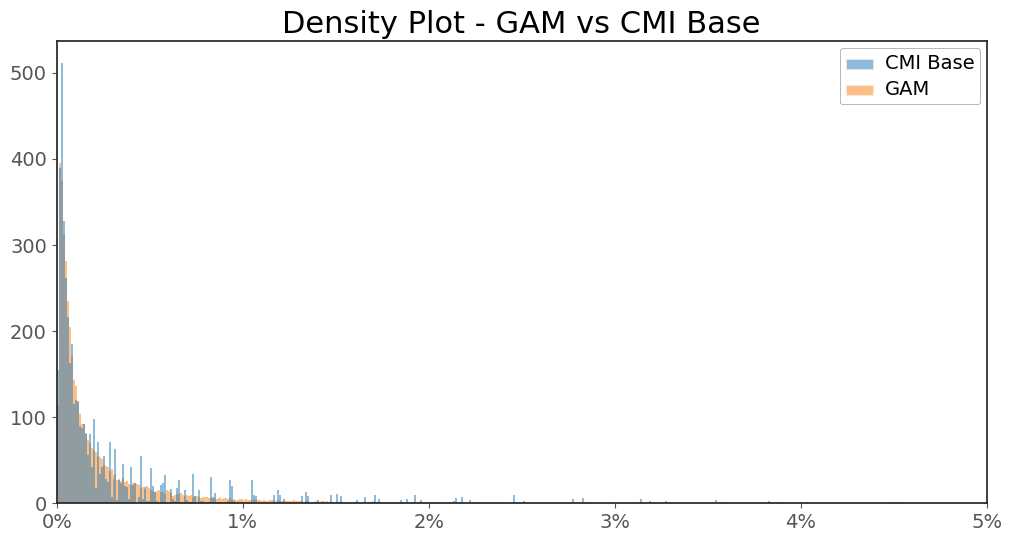

In [0]:
###########################################################################
###########################################################################

random_sample = 50000
random_seed = 999
color_list = ["tab:blue", "tab:orange"]
title = "Density Plot - GAM vs CMI Base"
x_axis_range = (0, 0.05)

###########################################################################
###########################################################################

dum = ypred_test_df[[cmi_freq, new_model_freq]].rename(
    columns={
        cmi_freq: "CMI Base",
        new_model_freq: "GAM",
    }
).sample(n=random_sample, random_state=random_seed)

plt.rcParams["figure.figsize"] = [12, 6]
fig, ax = plt.subplots(1)

sns.histplot(
    data=dum,
    kde=False,
    ax=ax,
    stat="density",
    palette=color_list,
    legend=True,
    alpha=0.5,
)

ax.set_xlim(x_axis_range[0], x_axis_range[1])
ax.set_title(title, fontsize=title_fontsize)
ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
ax.set_ylabel("")
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))
ax.grid(False)
ax.set_facecolor("white")

legend = ax.get_legend()
legend.set_frame_on(True)  
legend.get_frame().set_facecolor('white') 
legend.get_frame().set_edgecolor('grey')  
for text in legend.get_texts():
    text.set_fontsize(tick_fontsize)

In [0]:
corr, _ = pearsonr(ypred_test_df[cmi_freq], ypred_test_df[new_model_freq])
print(f"Correlation between GAM and CMI Base: {corr:.2%}")

Correlation between GAM and CMI Base: 98.28%


### Model Performance Assessment

In [0]:
gam_dev = utility.total_poisson_dev(
    y=ypred_test_df[claim_count],
    y_pred=ypred_test_df[new_model_count],
)
cmi_dev = utility.total_poisson_dev(
    y=ypred_test_df[claim_count],
    y_pred=ypred_test_df[cmi_base],
)
print(f"{'GAM':<9}: {gam_dev:,.0f}")
print(f"{'CMI Base':<9}: {cmi_dev:,.0f}")


GAM      : 52,913
CMI Base : 52,946


In [0]:
predict = [new_model_count, cmi_base]

d = utility.double_lift_plot(
    ypred_test_df,
    predict,
    claim_count,
    weight,
    endpoint_quantile=[0.01, 0.95],
)

mape_gam = mean_absolute_percentage_error(
    d[claim_count], d[new_model_count], sample_weight=d[weight]
)
mape_expected = mean_absolute_percentage_error(
    d[claim_count], d[cmi_base], sample_weight=d[weight]
)
print(f"{'MAPE - GAM':<15}: {mape_gam:.2%}")
print(f"{'MAPE - CMI Base':<15}: {mape_expected:.2%}")

d

MAPE - GAM     : 6.09%
MAPE - CMI Base: 8.39%


,ratio_band,IncurredClaims,gam_claim_count,ExpectedClaims,LivesExposure
band,,,,,
1,"(0.405, 0.8]",0.000914,0.000847,0.001137,7.514701e+05
2,"(0.8, 0.9]",0.001157,0.001075,0.001257,1.407873e+06
3,"(0.9, 1.0]",0.001326,0.001296,0.001364,1.793911e+06
4,"(1.0, 1.1]",0.001557,0.001557,0.001487,1.446446e+06
5,"(1.1, 1.2]",0.001701,0.001708,0.001492,8.788603e+05
6,"(1.2, 1.3]",0.001487,0.001688,0.001359,4.422806e+05
7,"(1.3, 1.4]",0.001029,0.001360,0.001014,2.313106e+05
8,"(1.4, 1.5]",0.000965,0.001052,0.000730,1.219757e+05
9,"(1.5, 9.41]",0.000367,0.000577,0.000352,1.697296e+05


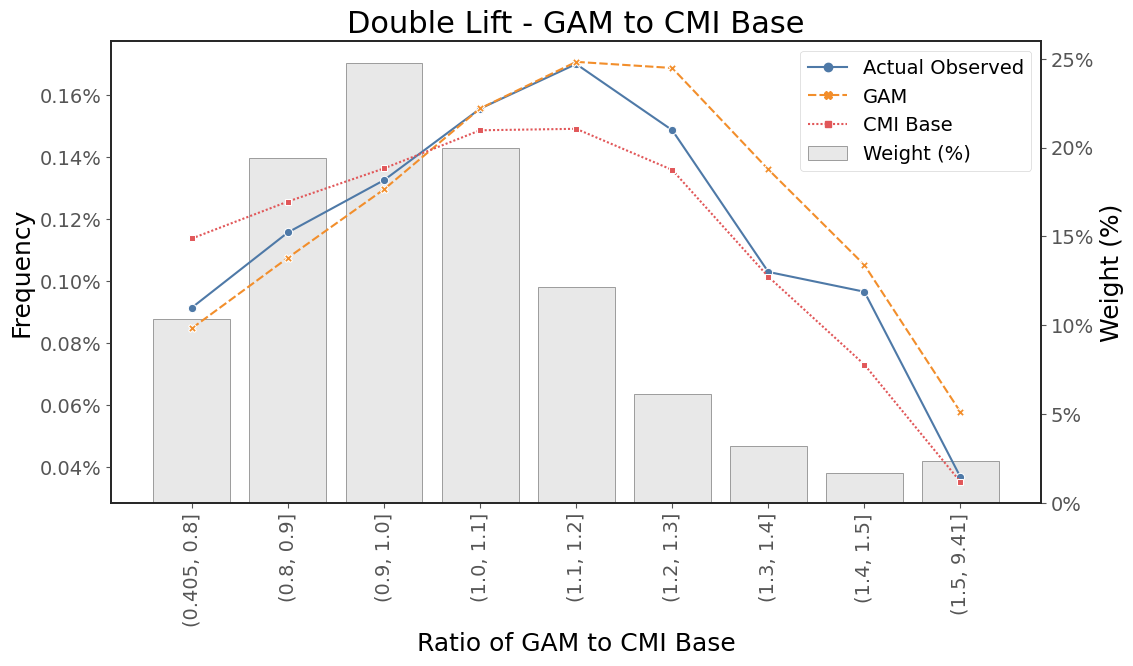

In [0]:
###########################################################################
###########################################################################

title = "Double Lift - GAM to CMI Base"
leftylabel = "Frequency"
rightylabel = "Weight (%)"
palette = ["#4e79a7", "#f28e2b", "#e15759"]

###########################################################################
###########################################################################

plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25

columns = {
    claim_count: "Actual Observed",
    new_model_count: "GAM",
    cmi_base: "CMI Base",
}

fig, ax = plt.subplots(figsize=(12, 6))

d.rename(
    columns=columns,
    inplace=True,
)
sns.lineplot(
    data=d[columns.values()],
    ax=ax,
    markers=True,
    palette=palette,
)
ax.xaxis.set_ticks(np.arange(1, len(d) + 1, 1))
xticklabels = d.ratio_band.to_list()

vals = ax.get_yticks()
diff = np.min(np.diff(vals))
dp = utility.round_down_to_power_of_10(diff)
dp = int(max(np.abs(np.log10(dp)) - 2, 0))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.{dp}%}"))

ax.set_ylabel(leftylabel, fontsize=label_fontsize)
ax.set_xlabel(
    f"Ratio of {columns[predict[0]]} to {columns[predict[1]]}",
    fontsize=label_fontsize,
)
ax.grid(False)
ax.set_facecolor("white")
ax.set_xticklabels(xticklabels, rotation=90, fontsize=tick_fontsize)

d[weight] /= d[weight].sum()

ax1 = ax.twinx()
ax1.bar(
    d.index,
    d[weight],
    color="lightgray",
    alpha=0.5,
    ec="k",
    label=rightylabel,
)
ax1.set_ylabel(rightylabel, fontsize=label_fontsize)

# Combine legends
lines, labels = ax.get_legend_handles_labels()
bars, bar_labels = ax1.get_legend_handles_labels()
ax.legend(lines + bars, labels + bar_labels, loc="best", fontsize=tick_fontsize, facecolor="white")

# format decimal
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.0%}"))
ax.tick_params(axis="both", which="major", labelsize=tick_fontsize)
ax1.tick_params(axis="y", which="major", labelsize=tick_fontsize)

ax.set_title(title, fontsize=title_fontsize)
ax.set_zorder(2)
ax.patch.set_alpha(0)
ax1.set_zorder(1)